# Chapter 4: Search in Complex Environments


## 4.1: Local Search and Optimization Problems

**Local search** algorithms don't keep track of the path traveled nor states reached. Some characteristics:
- (-) Not systematic (may not find a solution)
- (+) Use little memory
- (+) Can find (reasonable) solutions in large or infinite state spaces where systematic algos can't
- (+) Can solve **optimization problems** (find the best state for an **objective function**)

**State-space landscape**

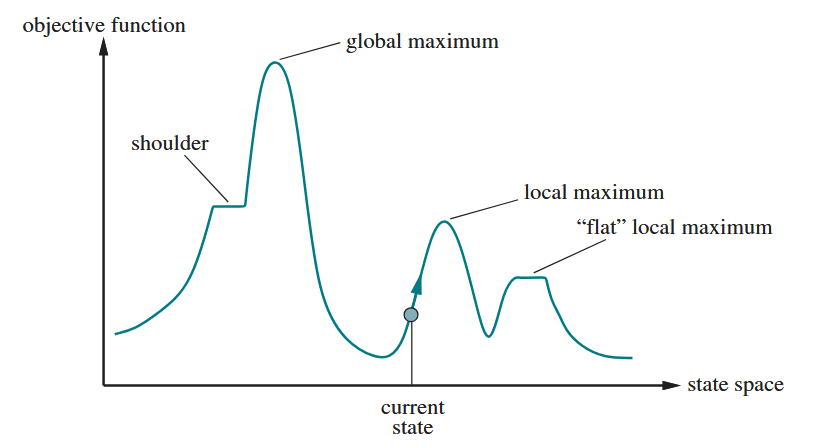

The x-axis represents the different states you can be in. The y-axis represents the value of the objective function. In the **hill-climbing** process, we start at a point and climb upward to attempt to find a **global maximum**. 

In some cases the y-axis represents a cost, in which case we'd actually want to go the opposite direction to find the **global minimum**. When we want to find the minimum, we call the search algorithm **gradient descent**. 

You can think of the cost function ($J$) as the negation of the value function ($f$):

$$
f(x) = -J(x)
$$

Let's make this plot with code!

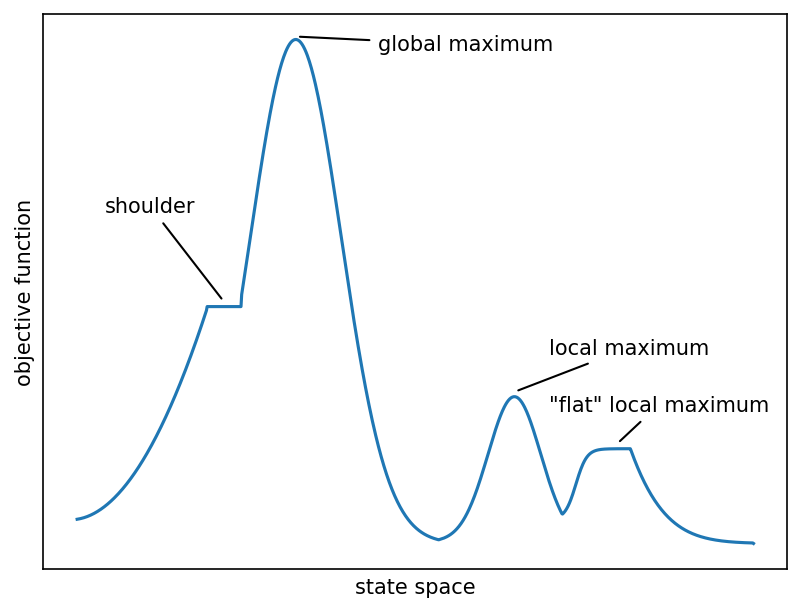

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math


# Utility: probability mass function of normal distribution
def normal_pmf(x, mean, std_dev):
    return (1 / (math.sqrt(2 * math.pi * std_dev**2))) * (
        math.e ** -(((x - mean) ** 2) / 2 * (std_dev**2))
    )


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Set up plot
figure = plt.figure()
figure.set_dpi(150)
axes_board = figure.add_subplot()
axes_board.set_ylabel("objective function")
axes_board.set_xlabel("state space")

axes_board.set_xticks([])
axes_board.set_yticks([])

x = np.linspace(1, 100, 1000)
condlist = [
    (x >= 0) & (x < 20),
    (x >= 20) & (x < 25),
    (x >= 25) & (x < 54),
    (x >= 54) & (x < 72),
    (x >= 72) & (x < 82),
    (x >= 82) & (x < 100),
]

funclist = [
    lambda x: ((x * 0.8) ** 2) / 11.5 + 2.5,
    lambda _: 25,
    lambda x: normal_pmf(x, 33, 0.15) * 20,
    lambda x: normal_pmf(x, 65, 0.26) * 10 + 0.15,
    lambda x: sigmoid((x - 74) * 1.25) * 7.5 + 2.5,
    lambda x: normal_pmf(x, 61.6, 0.1) * 20,
]

y = np.piecewise(x, condlist, funclist)

axes_board.plot(x, y)

# Annotations
arrow_props = {"arrowstyle": "-"}
axes_board.annotate("shoulder", xy=(22.5, 25.5), xytext=(5, 35), arrowprops=arrow_props)
axes_board.annotate(
    "global maximum", xy=(33, 53.5), xytext=(45, 52), arrowprops=arrow_props
)
axes_board.annotate(
    "local maximum", xy=(65, 16), xytext=(70, 20), arrowprops=arrow_props
)
axes_board.annotate(
    '"flat" local maximum', xy=(80, 10.5), xytext=(70, 14), arrowprops=arrow_props
)


plt.show()

### 4.1.1: Hill-climbing search

Hill-climbing keeps track of one current state and each iteration moves to the neighboring state with the highest value. It heads in the direction of **steepest descent**.

The book uses the **8-queens problem** as an example to showcase the hill-climbing algorithm:
- Place 8 queens on a chess board so that no queen attacks another
- A heuristic cost function h is the number of pairs of queens that are currently attacking each other. This is 0 for a solution

It's important to note that the book and my code "will use a **complete-state formulation**, which means each state has all the components of a solution, but they might not all be in the right place." More concretely, each state will have the position of all 8 queens, whereas you could try to solve the problem by placing one queen at a time, such that the state space could be larger, as it'd contain all possible states with 1, 2, 3... 8 queens.

Let's code up an environment to test 8-queens. Here's the image from the textbook we're trying to simulate (Figure 4.3):

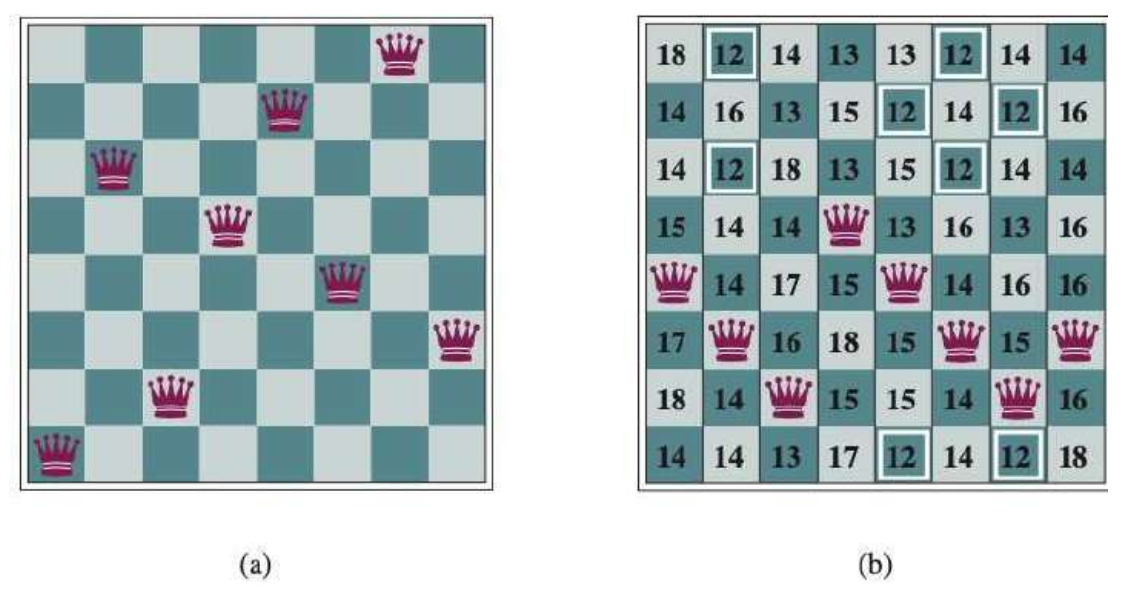

First, we'll just set up a way to visualize the data, and use random cost values before we define a cost function later.

We put a white square in any space that has the lowest cost value. If the cost is 0, the square is green.

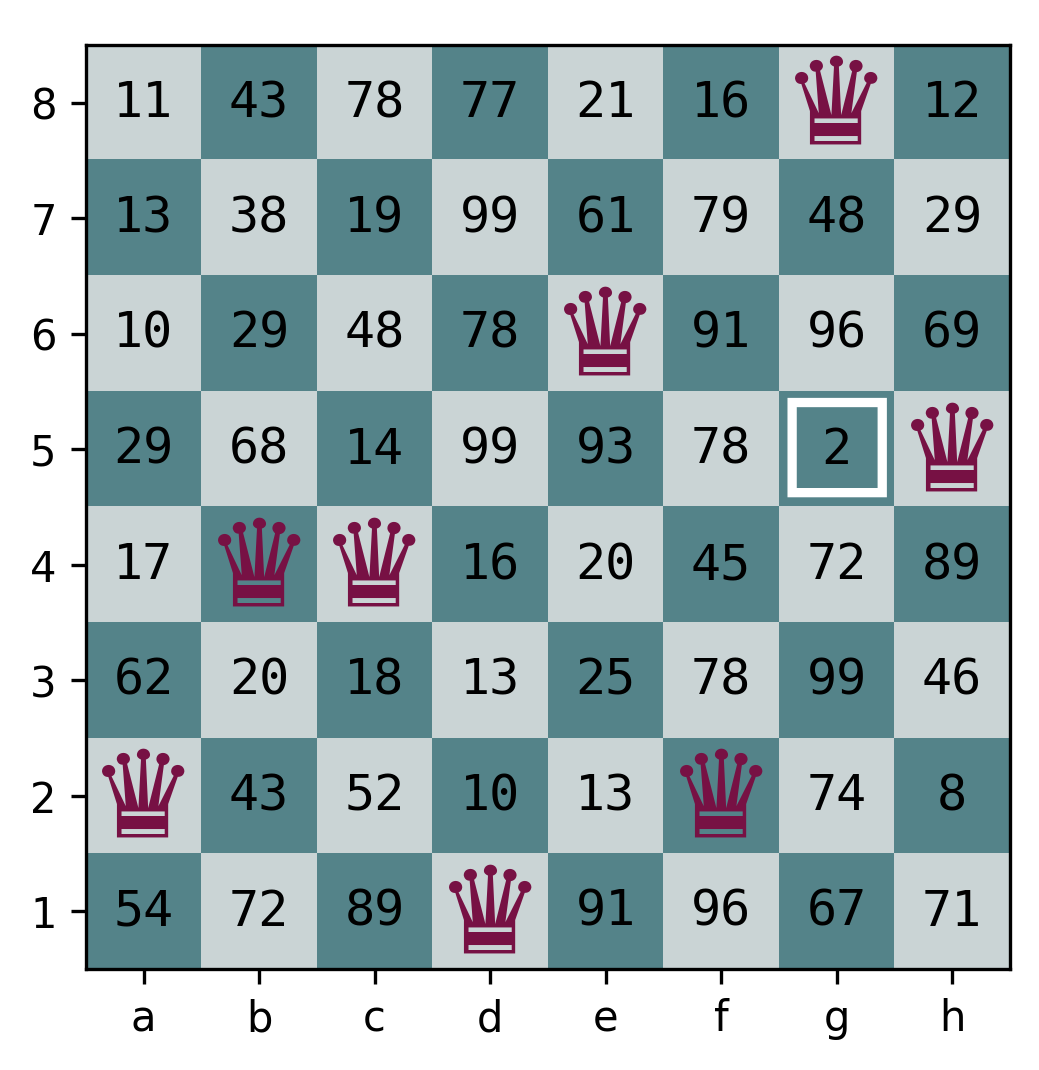

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import Any


# First write a function that renders a chess board with queens and
# optionally numbers representing the total cost if a queen is moved within its column
def plot_board(queen_rows: np.ndarray, costs=None):
    """Shows a plot of the chess board, with queens and optionally costs per cell

    Args:
        queen_positions: An array of ints in the range from 0 to 7 indicating which
          row the queen in the ith column is placed. row 0 is at the top.
        costs: optional 2d array (8x8) of costs corresponding to each cell representing
          the total cost if the queen in the jth column was moved to ith row.
    """
    figure = plt.figure(figsize=(4, 4))
    figure.set_dpi(300)
    axes = figure.add_subplot()
    axes.set_xticks(range(8), ["a", "b", "c", "d", "e", "f", "g", "h"])
    axes.set_yticks(np.arange(7, -1, -1), np.arange(1, 9))

    # Generates xy data in alternating 0 and 1 based on indices into the 2d array
    board_colors = np.indices((8, 8)).sum(axis=0) % 2

    # Colors
    color_map = ListedColormap(["#CAD4D5", "#548389"])

    axes.imshow(board_colors, cmap=color_map)

    # find the lowest cost to highlight it in the cells it appears
    lowest_cost = 0
    if costs is not None:
        lowest_cost = np.min(costs)

    # Place the queens and costs
    for row in range(8):
        for col in range(8):
            is_queen = queen_rows[col] == row
            if is_queen:
                value = "♛"
                font_size = 36
                color = "#771144"
            elif costs is not None:
                value = str(costs[row][col])
                font_size = 12
                color = "black"
            else:
                continue

            plt.text(
                col,
                row,
                value,
                horizontalalignment="center",
                verticalalignment="center",
                color=color,
                fontsize=font_size,
                fontfamily="monospace",
            )

            if costs is not None and costs[row][col] == lowest_cost:
                plt.text(
                    col,
                    row - 0.05,
                    "□",
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if lowest_cost > 0 else "green",
                    fontsize=40,
                    fontfamily="monospace",
                )

    plt.show()


rng = np.random.default_rng()
costs = rng.integers(1, 100, size=(8, 8))
plot_board(rng.choice(range(8), 8, replace=True), costs)

Now that we have a way to visualize a state and neighboring state costs, lets define the actual cost function. It should be the number of pairs of queens attacking each other. 

In this version of the problem, we only allow one queen per column to simplify the state space and the calculations. Therefore, to represent the state we use a one-dimensional array that contains the index of which row a queen is at in the ith column.

In [4]:
def cost(queen_rows: np.ndarray):
    total_cost = 0
    positions = list(enumerate(queen_rows))
    for a in positions:
        for b in positions[a[0] + 1 :]:
            if is_attacking(a, b):
                total_cost += 1
    return total_cost


def is_attacking(a: tuple[int, int], b: tuple[int, int]):
    # row
    if a[0] == b[0]:
        return True
    # column
    if a[1] == b[1]:
        return True
    # diagonal
    if abs(b[0] - a[0]) == abs(b[1] - a[1]):
        return True
    return False

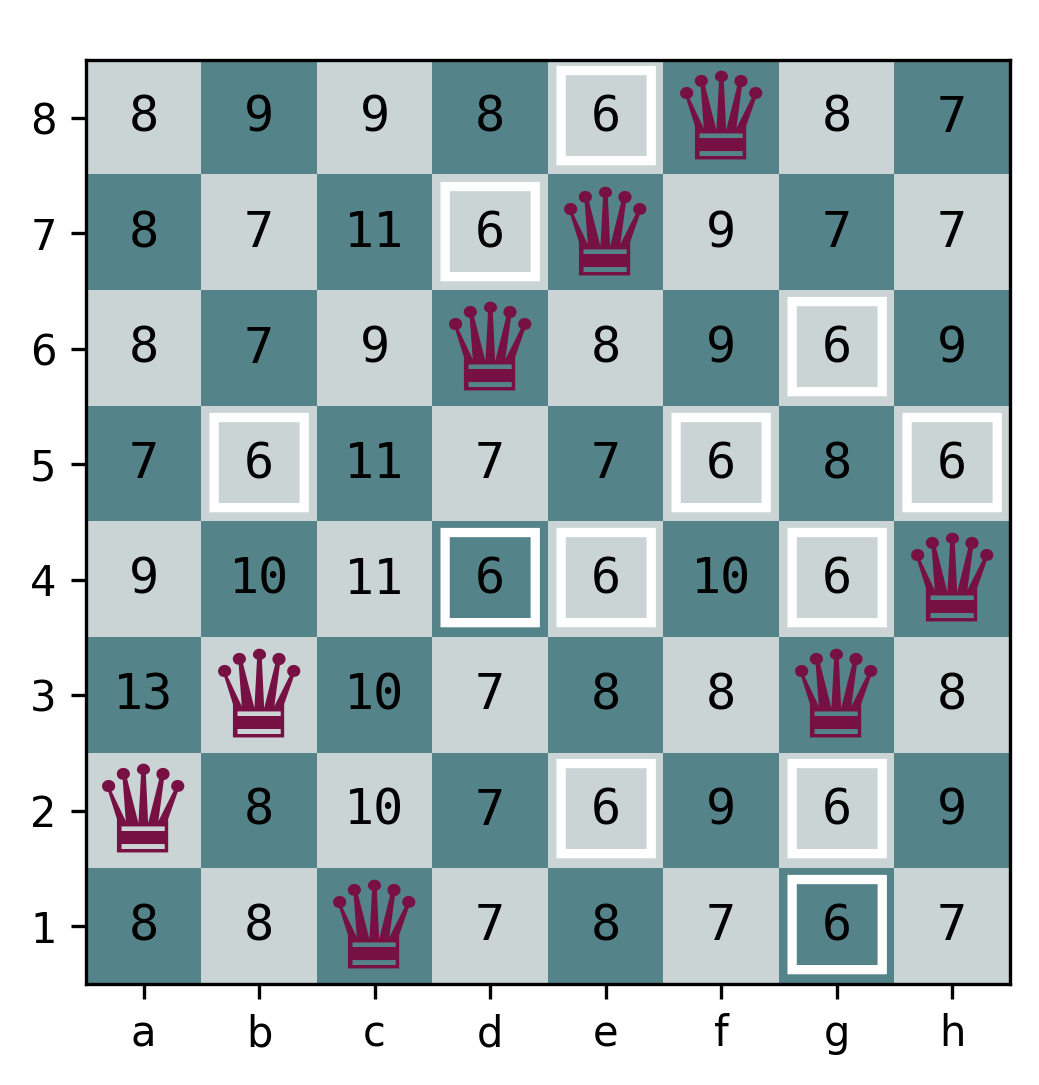

In [5]:
# fill positions randomly
queen_rows = rng.choice(range(8), 8, replace=True)
current_cost = cost(queen_rows)

# calculate neighboring state costs
costs = np.full((8, 8), -1)
for row in range(8):
    for col in range(8):
        # Use current cost if this is the same state as has already been calculated
        if queen_rows[col] == row:
            costs[row][col] = current_cost
            continue
        new_rows = queen_rows.copy()
        new_rows[col] = row
        costs[row][col] = cost(new_rows)

plot_board(queen_rows, costs)

Now let's define the search algorithms themselves. We have hill climbing and gradient descent, which are the same thing in opposite directions:

In [6]:
from collections.abc import Callable

# Type definition for a state in our problem. In our case (8-queens) this is an ndarray
# vector with 8 elements, each representing the row index of the queen in the ith column.
type State = np.ndarray

MAX_ITERATIONS = 50


def hill_climbing(
    state: State,
    value_function: Callable[[State], int],
    get_neighbors: Callable[[State], np.ndarray],
    state_history: list[State] | None = None,
) -> State:
    """Local search algorithm that returns a state that is a local maximum

    Adapted from Figure 4.2

    Args:
        state: The current or initial state
        value_function: function that returns the value of a given state
        get_neighbors: function that returns a list of all the neighboring states
        state_history: if an empty list is passed in, will record all the states
            on the path, including the initial and final states

    Returns:
        A state that is a local maximum
    """
    current_state = state
    if state_history is not None:
        state_history.append(current_state)
    current_value = value_function(state)
    current_iteration = 0
    while current_iteration < MAX_ITERATIONS:
        neighbors = get_neighbors(current_state)
        highest_value_neighbor = neighbors[0]
        highest_value = value_function(highest_value_neighbor)
        for neighbor in neighbors:
            value = value_function(neighbor)
            if value > highest_value:
                highest_value_neighbor = neighbor
                highest_value = value
        if highest_value <= current_value:
            return current_state
        current_state = highest_value_neighbor
        if state_history is not None:
            state_history.append(current_state)
        current_value = highest_value
        current_iteration += 1
    return current_state


# Same as hill climbing, but the cost function is negation of value function
def gradient_descent(
    state: State,
    cost_function: Callable[[State], int],
    get_neighbors: Callable[[State], np.ndarray],
    state_history: list[State] | None = None,
) -> State:
    value_function: Callable[[State], int] = lambda state: -cost_function(state)
    return hill_climbing(state, value_function, get_neighbors, state_history)

Now create the dependencies of these algorithms, execute, and plot the result.

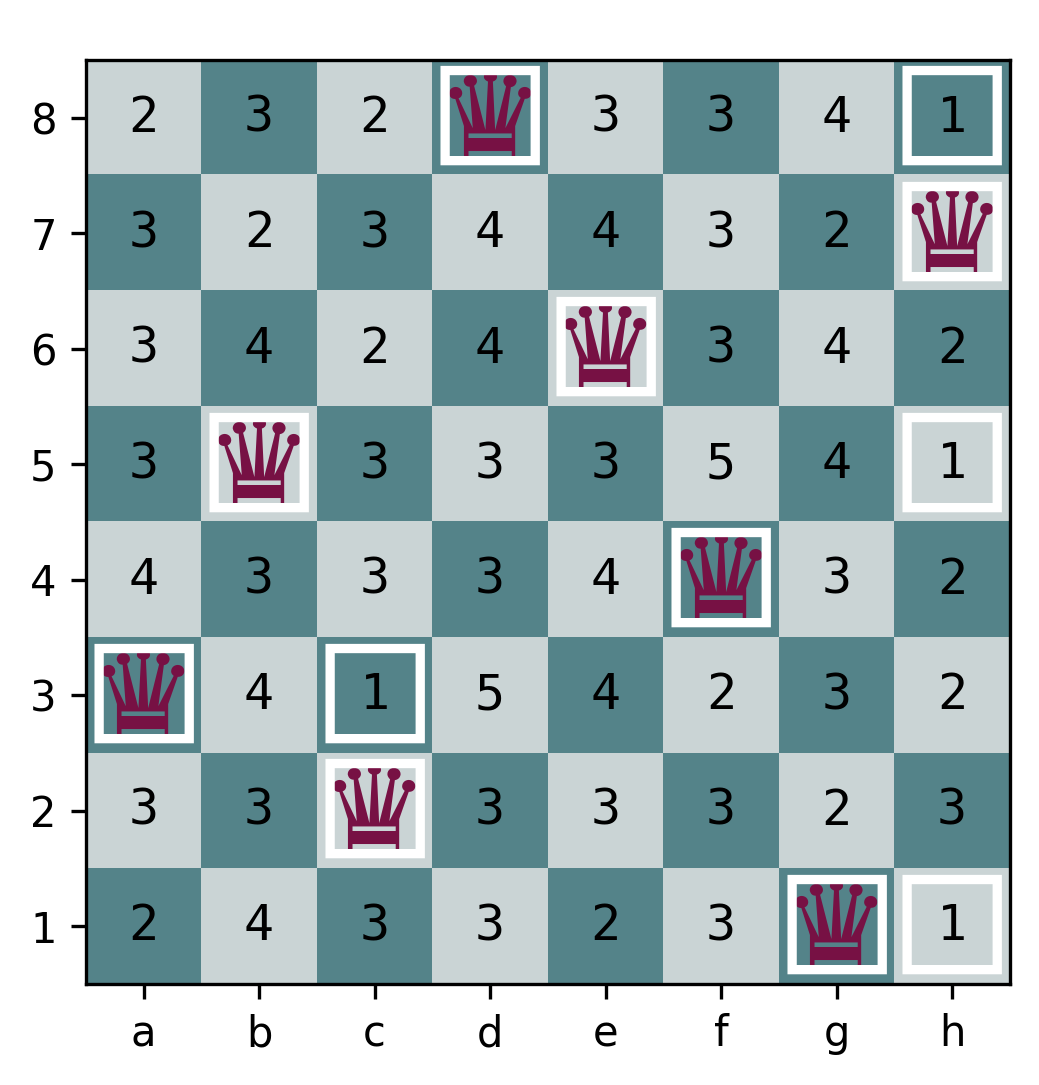

In [7]:
# Random initial state
initial_state = rng.choice(range(8), 8, replace=True)


def get_neighbors(queen_rows: State) -> np.ndarray:
    neighbors = []
    for i in range(8):
        for j in range(8):
            if j == queen_rows[i]:
                continue
            state = queen_rows.copy()
            state[i] = j
            neighbors.append(state)
    return np.array(neighbors)


state_history = []
local_minimum_state = gradient_descent(
    initial_state, cost, get_neighbors, state_history
)
local_minimum_cost = cost(local_minimum_state)


# calculate neighboring state costs
def get_neighbor_costs(state: State):
    costs = np.full((8, 8), -1)
    for row in range(8):
        for col in range(8):
            new_rows = state.copy()
            new_rows[col] = row
            costs[row][col] = cost(new_rows)
    return costs


plot_board(local_minimum_state, get_neighbor_costs(local_minimum_state))

Now that we can do hill-climbing / gradient descent and visualize the result, it'd be nice to visualize the search path. We can modify the plotting function and use matplotlib animations to step through the path.

We can also plot the cost after each iteration on another plot alongside each state to see the shape of the path with respect to cost.

I hypothesize that the path cost plot will be small because it usually takes few moves to reach a local minimum, but that's okay. It's good for practice.

In [ ]:
import matplotlib.animation as animation
import matplotlib.axes
import matplotlib.artist
from typing import Iterable
from IPython.display import HTML


def create_path_figure(state_history):
    figure = plt.figure(figsize=(8, 4))
    figure.set_dpi(300)

    # Create the board subplot
    axes_board = figure.add_subplot(1, 2, 1)
    axes_board.set_xticks(range(8), ["a", "b", "c", "d", "e", "f", "g", "h"])
    axes_board.set_yticks(np.arange(7, -1, -1), np.arange(1, 9))
    axes_board.set_title("Board")

    # Generates xy data in alternating 0 and 1 based on indices into the 2d array
    board_colors = np.indices((8, 8)).sum(axis=0) % 2

    # Colors
    color_map = ListedColormap(["#CAD4D5", "#548389"])

    axes_board.imshow(board_colors, cmap=color_map)

    # Create the graph subplot
    axes_graph = figure.add_subplot(1, 2, 2)
    axes_graph.set_title("Cost")
    axes_graph.set_xlabel("State index")
    axes_graph.set_box_aspect(1)
    # Both x and y can only be non-negative integers
    axes_graph.set_xticks(np.arange(len(state_history)))
    axes_graph.set_xbound(0)
    axes_graph.set_ybound(0)
    axes_graph.grid(True, which="both")

    return (figure, (axes_board, axes_graph))


# Use a list of text artists so we can remove the ones from last frame
# before drawing the new ones
text_artists = []
# Keep track of the costs up to this point
cost_history = [cost(state) for state in state_history]


def update(
    axes_board: matplotlib.axes.Axes,
    axes_graph: matplotlib.axes.Axes,
    i: int,
    state: State,
) -> Iterable[matplotlib.artist.Artist]:
    # 1. Clear any existing text artists
    for text in text_artists:
        text.remove()
    text_artists.clear()

    # 2. Generate neighboring costs
    costs = get_neighbor_costs(state)
    # find the lowest cost to highlight it in the cells it appears
    lowest_cost = 0
    if costs is not None:
        lowest_cost = np.min(costs)

    # 3. Update board
    for row in range(8):
        for col in range(8):
            is_queen = state[col] == row
            if is_queen:
                value = "♛"
                font_size = 36
                color = "#771144"
            elif costs is not None:
                value = str(costs[row][col])
                font_size = 12
                color = "black"
            else:
                continue

            cost_text = axes_board.text(
                col,
                row,
                value,
                horizontalalignment="center",
                verticalalignment="center",
                color=color,
                fontsize=font_size,
                fontfamily="monospace",
            )
            text_artists.append(cost_text)

            if costs is not None and costs[row][col] == lowest_cost:
                square_text = axes_board.text(
                    col,
                    row - 0.05,
                    "□",
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if lowest_cost > 0 else "green",
                    fontsize=40,
                    fontfamily="monospace",
                )
                text_artists.append(square_text)

    # 4. Update cost graph
    axes_graph.bar(
        np.arange(len(cost_history[: i + 1])), cost_history[: i + 1], color="#548389"
    )

    return [axes_board, axes_graph]


figure, (axes_board, axes_graph) = create_path_figure(state_history)
ani = animation.FuncAnimation(
    fig=figure,
    init_func=(lambda: []),  # Necessary or else the animation starts at second frame
    func=(lambda frame: update(axes_board, axes_graph, frame[0], frame[1])),
    frames=list(enumerate(state_history)),
    repeat=False,
    interval=2000,
)
# Close the plot to avoid Jupyter showing another image of the plot after the animation
plt.close()
HTML(ani.to_jshtml())

[**Hill-climbing variants**](https://en.wikipedia.org/wiki/Hill_climbing#Variants):
* **Stochastic** - Chooses a random uphill state. Could use a probability distribution weighed by steepness
    * **First-choice** - implementation of Stochastic hill-climbing, randomly generating neighbors, choosing the first of higher value.
        * Useful when states have many possible successors.
* **Random-restart** - Performs a series of hill-climbing searches from random starting states until a goal state is found
    * "If at first you don't succeed, try, try again."
    * *Complete* (probability of finding a solution is 1) because it will eventually pick a random initial state that is a goal state.

Key point: "The success of the hill-climbing algorithm is heavily dependent on the shape of the state-space landscape."

It can be good to find a decent local maximum after a small number of restarts, but on many state-spaces may be infeasible for further increasing the value of a solution.

### 4.1.2: Simulated Annealing

[**Annealing**](https://en.wikipedia.org/wiki/Annealing_(materials_science)) - the process used to temper or harden metals and glass by heating them to a high temperature and then gradually cooling them, allowing the material to reach a low-energy state

See also: [Diffusion](https://en.wikipedia.org/wiki/Diffusion)

**[Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing)**
    - [wikipedia] - "a probabilistic technique for approximating the global optimum of a given function"
        - "It is a *[metaheuristic](https://en.wikipedia.org/wiki/Metaheuristic)* (interesting wiki page) to approximate global optimization in a large search space for an optimization problem."

1. Start a search with a temperature $T$ that is cooled down each iteration / time step $t$ by a schedule function $schedule(t) = T'$. 
1. Each iteration, we randomly select a successor of the current state, then compute it's difference in energy $\Delta E = value(current) - value(next)$. 
1. Then, we choose $next$ with the [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) ($e^{-\Delta E / T})$, otherwise keep the $current$ state.
1. Once the temperature $T$ reaches 0, we return the current state as our approximate global optimum

Note: Because of some property of the [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution), all the probability is concentrated on the global optimum. This means simulated annealing will find the global optimum with probability approaching 1. This is an exercise for the reader (me) 

### 4.1.3: Local beam search

**Local beam search** "keeps track of *k* states rather than just one," beginning with *k* random states and at each step generating all successors of each *k* states. It then selects the best *k* states from the complete successor set by value.
* Is vulnerable to decreasing diversity over time, as the *k* states may become clumped in a local optimum.

Variant: **stochastic beam search** - Instead of choosing *k* successors with highest value, choose from sucessors by weighted random sampling -- Higher value states have a higher probability of being selected.

### 4.1.4: Evolutionary algorithms

* "Can be seen as variants of stochastic beam search" motivated by the metaphor of natural selection
    * States ~ **population**
        * State ~ **individual**
    * Value function ~ **fitness**
    * Successor states ~ **offspring**
    * Successor selection ~ **recombination** - procedure to generate offspring

Different evolutionary algorithms vary in the following ways:
* Size of population
* Representation of individuals
    * in **genetic algorithms**, a string over a finite alphabet (often Boolean string)
        * Similar to how DNA is a string over {ACTG} 
    * in **evolution strategies**, a sequence of real numbers
    * in **genetic programming**, a computer program
* Mixing number (number of parents), $\rho$, that form offspring
    * Most commonly: $\rho = 2$
    * When $\rho = 1$, it's effectively stochastic beam search / asexual reproduction
* Recombination procedure
    * Example 1: If $\rho = 2$, randomly select a **crossover point** (index into the string) to split each of the parent strings, recombine the first half of the first string with the second half of the second string, and vice versa, to produce two new individuals
    * Example 2: Randomly select $n$ individuals (where $n > \rho$), sort by fitness, choose $\rho$ most fit as parents
* **Selection** process - how the algorithm chooses parents for the next generation from the current population after recombination
* **Mutation rate** - how often offspring have random mutations applied to their representation
    * For example, flipping every bit in the offsprings string with some propability before finalizing the individual.
* The makeup of the next generation:
    * Just the newly formed offspring
    * Optionally include some top fitness parents 
        * Called **elitism** - guarantees overall fitness will not decrease
    * **Culling** - discard individuals below a threshold (fitness)

Note: When I was reading this section, I was confused about the difference between the "selection process" and the "makeup of the next generation". The key difference is where in the evolution pipeline they occur, and their inputs / outputs.
* Selection occurs toward the beginning of the iteration, after the population has been finalized as the output from the previous iteration. Selection takes the population and selects $\rho$ parents.
* Finalizing the output population occurs after the offspring have been created, and involves filtering and selection of individuals from the offsprings and the previous population.
        
The key difference between genetic algorithms and stochastic beam search is the crossover operation, which is beneficial to the search to the extent that each state representation contains contiguous blocks of characters that work together to increase the fitness, or that form larger constructs or behaviors that interact with other blocks with greater purpose.

Relatedly, in genetic algorithm theory, a **schema** is a substring of an individual's representation.
* The schema describes a subset of possible individuals whose representations match it.
* As an example in 8 queens, one schema is 246\*\*\*\*\*, which could be a beneficial block because it places the first 3 queens in a way where none of them are attacking eachother.
* Strings that match the schema (like 24613578) are called **instances** of that schema.
* **Key point**: "Genetic algorithms work best when schemas correspond to meaningful components of a solution."

## 4.2: Local Search in Continuous Spaces
Resources:
* [3Blue1Brown -  From Newton’s method to Newton’s fractal (which Newton knew nothing about)](https://www.youtube.com/watch?v=-RdOwhmqP5s)
* [Khan Academy - The Hessian matrix | Multivariable calculus](https://www.youtube.com/watch?v=LbBcuZukCAw)